In [ ]:
from typing import Any, Iterable
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from datasets import load_dataset
import sys
from pathlib import Path
from tqdm import tqdm
from text2features import FeatureExtractorPipeline, ExtCtx
from text2features_paths import FEATURE_PIPELINE_RESOURCES

sys.path.append(str(Path.cwd().parent))
from book_segmenting import TextSegmenter
from utils import DATA_DIR

feature_extractor = FeatureExtractorPipeline(resources=FEATURE_PIPELINE_RESOURCES)

SEGMENT_CHARS_MIN = 150
SEGMENT_CHARS_MAX = 500
segmenter = TextSegmenter(segment_size=(SEGMENT_CHARS_MIN, SEGMENT_CHARS_MAX))


class Dataset:
    MIN_TEXT_LENGTH = 60
    MAX_TEXT_LENGTH = 500

    def __init__(
        self,
        name: str,
        src: Iterable[Any],
        take: int,
        skip: int = 0,
        text_getter=None,
        deduplicate=False,
        segment=False,
        check_length=True,
    ):
        self.name = name
        self.src = iter(src)
        self.take = take
        self.skip = skip
        self.texts: list[str] | None = None
        self.contexts: list[ExtCtx] | None = None
        self.features: list[NDArray[np.float32]] | None = None
        self.text_getter = text_getter
        self.deduplicate = deduplicate
        self.segment = segment
        self.check_length = check_length

    def process(
        self, deduplicate: bool | None = None, segment: bool | None = None
    ) -> list[ExtCtx]:
        if deduplicate is None:
            deduplicate = self.deduplicate
        if segment is None:
            segment = self.segment

        self.texts = []
        self.contexts = []
        self.features = []
        if deduplicate:
            seen = set()
        taken = 0
        to_skip = self.skip

        with tqdm(total=self.take, desc="Processing texts", unit="text") as pbar:
            while taken < self.take:
                try:
                    text = next(self.src)
                except StopIteration:
                    break
                if to_skip > 0:
                    to_skip -= 1
                    continue

                if self.text_getter is not None:
                    text = self.text_getter(text)
                if not text:
                    continue

                text = FeatureExtractorPipeline.preprocess(text)
                if self.check_length and len(text.strip()) < Dataset.MIN_TEXT_LENGTH:
                    continue

                if segment:
                    segments = [
                        seg
                        for seg in segmenter.segment_text(text)
                        if seg
                        and (
                            not self.check_length
                            or (seg_len := len(seg.strip())) >= Dataset.MIN_TEXT_LENGTH
                            and seg_len <= Dataset.MAX_TEXT_LENGTH
                        )
                    ]
                    if len(segments) == 0:
                        continue
                    text = segments[len(segments) // 2]
                else:
                    if self.check_length and len(text) > Dataset.MAX_TEXT_LENGTH:
                        continue

                if deduplicate:
                    if text in seen:
                        continue
                    seen.add(text)
                ctx = feature_extractor.get_ctx(text)
                features = feature_extractor.extract(text, preprocess=False, ctx=ctx)
                if deduplicate:
                    feat_tuple = tuple(features.tolist())
                    if feat_tuple in seen:
                        continue
                    seen.add(feat_tuple)
                self.texts.append(text)
                self.contexts.append(ctx)
                self.features.append(features)
                taken += 1
                pbar.update(1)

        return self.contexts

    def __iter__(self):
        if self.contexts is None:
            raise ValueError("Dataset not processed yet. Call process() first.")
        return iter(self.contexts)

    def __len__(self):
        if self.contexts is None:
            raise ValueError("Dataset not processed yet. Call process() first.")
        return len(self.contexts)

    def save_as_parquet(self, labels: list[Any] | None = None):
        if self.texts is None or self.features is None:
            raise ValueError("Dataset not processed yet. Call process() first.")
        df = pd.DataFrame(
            {"text": self.texts, "features": [feat.tolist() for feat in self.features]}
        )
        if labels is not None:
            if len(labels) != len(self.texts):
                raise ValueError("Labels length does not match texts length.")
            df["label"] = labels
        df.to_parquet(
            DATA_DIR / "datasets" / "large" / f"{self.name}.parquet", index=False
        )

/home/terra/Projects/vis-desc/modules/lab/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-22 17:28:18.190436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761146898.209465  310564 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761146898.214974  310564 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 17:28:18.234849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

using device cpu


In [3]:
ds_high_flickr = load_dataset(
    "CaptionEmporium/flickr-megalith-10m-internvl2-multi-caption",
    split="train",
    streaming=True,
)
ds_flickr30k = load_dataset("embedding-data/flickr30k_captions_quintets", split="train")
ds_coco = load_dataset("sentence-transformers/coco-captions", split="train")
ds_sbu = load_dataset("vicenteor/sbu_captions", split="train", trust_remote_code=True)
with open(DATA_DIR / "datasets" / "large" / "movie_summaries.txt") as f:
    ds_movie_summaries = [line.strip() for line in f.readlines()]
ds_book_summaries = load_dataset("textminr/cmu-book-summaries", split="train")
with open(DATA_DIR / "datasets" / "large" / "book_dialogs.txt") as f:
    ds_book_dialogs = [line.strip() for line in f.read().split("\n\n")]
ds_wiki = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1", split="train")
ds_news = load_dataset("EdinburghNLP/xsum", split="validation")
ds_hotels = load_dataset("argilla/tripadvisor-hotel-reviews", split="train")
ds_yelp = load_dataset("Yelp/yelp_review_full", split="test")
ds_arxiv = load_dataset(
    "armanc/scientific_papers",
    "arxiv",
    split="validation",
    trust_remote_code=True,
    streaming=True,
)
AMAZON_CATEGORIES = [
    "Cell_Phones_and_Accessories",
    "Beauty_and_Personal_Care",
    "Electronics",
    "Grocery_and_Gourmet_Food",
    "CDs_and_Vinyl",
    "Musical_Instruments",
    "Magazine_Subscriptions",
    "Industrial_and_Scientific",
    "Software",
]
ds_amazon_reviews = []
N_TOTAL = 15000
for category in AMAZON_CATEGORIES:
    ds = iter(
        load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            f"raw_review_{category}",
            split="full",
            trust_remote_code=True,
            streaming=True,
        )
    )
    for i in range(N_TOTAL // len(AMAZON_CATEGORIES)):
        ds_amazon_reviews.append(next(ds))
while len(ds_amazon_reviews) < N_TOTAL:
    ds_amazon_reviews.append(next(ds))

In [4]:
datasets = [
    Dataset(
        "artif_5",
        ds_high_flickr,
        skip=2 * 1500,
        take=15000,
        text_getter=lambda x: x["caption_internlm2"],
    ),
    Dataset(
        "artif_4",
        ds_high_flickr,
        skip=2 * 1500,
        take=15000,
        text_getter=lambda x: x["caption_internlm2_short"],
    ),
    Dataset(
        "flickr30k",
        ds_flickr30k,
        skip=2 * 1500,
        take=15000,
        text_getter=lambda x: x["set"][0],
    ),
    Dataset(
        "coco", ds_coco, skip=2 * 500, take=5000, text_getter=lambda x: x["caption1"]
    ),
    Dataset("sbu", ds_sbu, skip=2 * 500, take=5000, text_getter=lambda x: x["caption"]),
    Dataset(
        "movie_summaries", ds_movie_summaries, skip=2 * 500, take=5000, segment=True
    ),
    Dataset(
        "book_summaries",
        ds_book_summaries,
        skip=2 * 500,
        take=5000,
        text_getter=lambda x: x["summary"],
        segment=True,
    ),
    Dataset("book_dialogs", ds_book_dialogs, skip=2 * 500, take=5000),
    Dataset(
        "wiki",
        ds_wiki,
        skip=2 * 1000,
        take=10000,
        text_getter=lambda x: x["text"].replace(" @-@ ", "-").replace(" @,@ ", ","),
        segment=True,
    ),
    Dataset(
        "news",
        ds_news,
        skip=2 * 500,
        take=5000,
        text_getter=lambda x: x["document"],
        segment=True,
    ),
    Dataset(
        "hotels", ds_hotels, skip=2 * 200, take=2000, text_getter=lambda x: x["text"]
    ),
    Dataset("yelp", ds_yelp, skip=2 * 300, take=3000, text_getter=lambda x: x["text"]),
    Dataset(
        "arxiv",
        ds_arxiv,
        skip=2 * 500,
        take=5000,
        text_getter=lambda x: x["abstract"],
        segment=True,
    ),
    Dataset(
        "amazon_reviews",
        ds_amazon_reviews,
        skip=2 * 500,
        take=5000,
        text_getter=lambda x: x["text"],
    ),
]

In [ ]:
for i, dataset in enumerate(datasets):
    print(f"--- Done: {i}/{len(datasets)} ---")
    dataset.process(deduplicate=True)
print("DONE")

--- Done: 0/14 ---


Processing texts: 100%|██████████| 15000/15000 [39:36<00:00,  6.31text/s] 


--- Done: 1/14 ---


Processing texts: 100%|██████████| 15000/15000 [15:11<00:00, 16.46text/s] 


--- Done: 2/14 ---


Processing texts:  90%|█████████ | 13504/15000 [10:16<01:08, 21.90text/s] 


--- Done: 3/14 ---


Processing texts: 100%|██████████| 5000/5000 [03:23<00:00, 24.62text/s]


--- Done: 4/14 ---


Processing texts: 100%|██████████| 5000/5000 [03:49<00:00, 21.78text/s]


--- Done: 5/14 ---


Processing texts: 100%|██████████| 5000/5000 [06:14<00:00, 13.36text/s]


--- Done: 6/14 ---


Processing texts: 100%|██████████| 5000/5000 [06:25<00:00, 12.97text/s]


--- Done: 7/14 ---


Processing texts: 100%|██████████| 5000/5000 [08:22<00:00,  9.95text/s]  


--- Done: 8/14 ---


Processing texts: 100%|██████████| 10000/10000 [14:39<00:00, 11.38text/s] 


--- Done: 9/14 ---


Processing texts: 100%|██████████| 5000/5000 [05:49<00:00, 14.32text/s]


--- Done: 10/14 ---


Processing texts: 100%|██████████| 2000/2000 [02:25<00:00, 13.75text/s]


--- Done: 11/14 ---


Processing texts: 100%|██████████| 3000/3000 [03:56<00:00, 12.67text/s]


--- Done: 12/14 ---


Processing texts: 100%|██████████| 5000/5000 [07:23<00:00, 11.26text/s]  


--- Done: 13/14 ---


Processing texts: 100%|██████████| 5000/5000 [05:14<00:00, 15.89text/s]


DONE


In [19]:
# Fill the missing examples in ds_flickr30k with second caption from the set
to_fill = 15000 - len(datasets[2].features)
if to_fill > 0:
    ds_flickr30k_2 = Dataset(
        "flickr30k",
        ds_flickr30k,
        skip=2 * 1500,
        take=to_fill,
        text_getter=lambda x: x["set"][1],
    )
    ds_flickr30k_2.process(deduplicate=True)
    datasets[2].texts.extend(ds_flickr30k_2.texts)
    datasets[2].contexts.extend(ds_flickr30k_2.contexts)
    datasets[2].features.extend(ds_flickr30k_2.features)

print(sum(len(ds.features) for ds in datasets))

Processing texts: 100%|██████████| 1496/1496 [00:56<00:00, 26.69text/s]


100000


In [20]:
datasets[0].save_as_parquet(labels=np.ones(len(datasets[0].features), dtype=int) * 5)
datasets[1].save_as_parquet(labels=np.ones(len(datasets[1].features), dtype=int) * 4)

In [21]:
import pickle

paths = [
    (int(path.stem.split("_")[-1]), path)
    for path in (DATA_DIR / "models").glob("ordinal_model_dataset_*.pkl")
]
# Reorder paths by dataset index
paths.sort(key=lambda p: p[0])

for dataset_idx, path in paths:
    with open(path, "rb") as f:
        model = pickle.load(f)
    X = np.array(datasets[dataset_idx].features)
    preds = model.predict(X)
    # Save
    print("saving", dataset_idx, datasets[dataset_idx].name, len(preds))
    datasets[dataset_idx].save_as_parquet(labels=preds)

saving 2 flickr30k 15000
saving 3 coco 5000
saving 4 sbu 5000
saving 5 movie_summaries 5000
saving 6 book_summaries 5000
saving 7 book_dialogs 5000
saving 8 wiki 10000
saving 9 news 5000
saving 10 hotels 2000
saving 11 yelp 3000
saving 12 arxiv 5000
saving 13 amazon_reviews 5000


In [ ]:
from utils import DATA_DIR

# Combine the individual parquet files into a single one
parquet_files = [
    (DATA_DIR / "datasets" / "large" / f"{ds.name}.parquet") for ds in datasets
]
dfs = []
for p in parquet_files:
    name = p.stem
    df = pd.read_parquet(p)
    df["dataset"] = name
    dfs.append(df)

df_combined = pd.concat(dfs, ignore_index=True)
df_combined.to_parquet(
    DATA_DIR / "datasets" / "large" / "combined.parquet", index=False
)

print("Label distribution:")
print(df_combined["label"].value_counts().sort_index())

Label distribution:
label
0    26440
1    15495
2     4428
3    20695
4    17942
5    15000
Name: count, dtype: int64


In [1]:
import pandas as pd
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR

df_combined = pd.read_parquet(DATA_DIR / "datasets" / "large" / "combined.parquet")

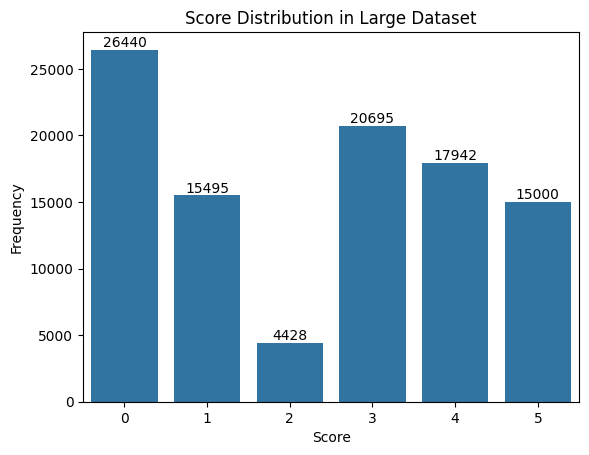

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot label distribution
ax = sns.countplot(x="label", data=df_combined, stat="count")
ax.bar_label(ax.containers[0])
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Score Distribution in Large Dataset")
plt.show()

In [8]:
# Compute and print dataset statistics
# - token count
# - sentence count
# - average sentence length
# - average document character length
# - average document token count
# - vocabulary size (unique tokens)

from collections import defaultdict
import numpy as np
from text2features import FeatureExtractorPipeline
from text2features_paths import FEATURE_PIPELINE_RESOURCES

extractors = FeatureExtractorPipeline(resources=FEATURE_PIPELINE_RESOURCES)

total_token_count = 0
total_sentence_count = 0
total_sent_length = 0
total_vocab = set()

# Lists to store per-document values for std calculation
doc_token_counts = []
doc_sentence_counts = []
doc_char_lengths = []
doc_sent_lengths = []

token_count_by_dataset = {}
sentence_count_by_dataset = {}
sent_length_by_dataset = {}
vocab_by_dataset = defaultdict(set)

# Lists to store per-document values per dataset for std calculation
doc_token_counts_by_dataset = defaultdict(list)
doc_sentence_counts_by_dataset = defaultdict(list)
doc_char_lengths_by_dataset = defaultdict(list)
doc_sent_lengths_by_dataset = defaultdict(list)

for index, row in tqdm(
    df_combined.iterrows(), total=len(df_combined), desc="Computing statistics"
):
    text = row["text"]
    dataset = row["dataset"]
    ctx = extractors.get_ctx(text)

    token_count = len(ctx.tokens)
    sentence_count = len(ctx.sents)

    total_token_count += token_count
    total_sentence_count += sentence_count
    sent_length = sum(len(sent.get_tokens()) for sent in ctx.sents)
    total_sent_length += sent_length
    lemmas = [token.lemma for token in ctx.tokens]
    total_vocab.update(lemmas)

    # Store per-document values
    doc_token_counts.append(token_count)
    doc_sentence_counts.append(sentence_count)
    doc_char_lengths.append(len(text))
    doc_sent_lengths.append(sent_length)

    if dataset not in token_count_by_dataset:
        token_count_by_dataset[dataset] = 0
        sentence_count_by_dataset[dataset] = 0
        sent_length_by_dataset[dataset] = 0

    token_count_by_dataset[dataset] += token_count
    sentence_count_by_dataset[dataset] += sentence_count
    sent_length_by_dataset[dataset] += sent_length
    vocab_by_dataset[dataset].update(lemmas)

    # Store per-document values per dataset
    doc_token_counts_by_dataset[dataset].append(token_count)
    doc_sentence_counts_by_dataset[dataset].append(sentence_count)
    doc_char_lengths_by_dataset[dataset].append(len(text))
    doc_sent_lengths_by_dataset[dataset].append(sent_length)

avg_token_count = total_token_count / len(df_combined)
avg_sentence_count = total_sentence_count / len(df_combined)
avg_sentence_length = total_sent_length / total_sentence_count
vocab_size = len(total_vocab)
df_combined["char_length"] = df_combined["text"].apply(len)
avg_char_length = df_combined["char_length"].mean()

# Calculate standard deviations
std_token_count = np.std(doc_token_counts)
std_sentence_count = np.std(doc_sentence_counts)
std_char_length = np.std(doc_char_lengths)
std_sent_length = np.std(doc_sent_lengths)

print("Overall LARGE dataset statistics:")
print("-------------------------------")
print("Dataset size:", len(df_combined))
print(f"Total token count: {total_token_count}")
print(f"Total sentence count: {total_sentence_count}")
print(f"Total vocabulary size (unique tokens): {vocab_size}")
print(f"Doc. avg character length: {avg_char_length:.2f} ± {2 * std_char_length:.2f}")
print(f"Doc. avg token count: {avg_token_count:.2f} ± {2 * std_token_count:.2f}")
print(
    f"Doc. avg sentence count: {avg_sentence_count:.2f} ± {2 * std_sentence_count:.2f}"
)
print(
    f"Doc. avg sentence length: {avg_sentence_length:.2f} ± {2 * std_sent_length:.2f}"
)

# Now per dataset
for dataset in token_count_by_dataset:
    dataset_size = len(df_combined[df_combined["dataset"] == dataset])
    avg_tokens = token_count_by_dataset[dataset] / dataset_size
    avg_sents = sentence_count_by_dataset[dataset] / dataset_size
    avg_sent_length = (
        sent_length_by_dataset[dataset] / sentence_count_by_dataset[dataset]
    )
    vocab_size_ds = len(vocab_by_dataset[dataset])

    # Calculate standard deviations per dataset
    std_tokens_ds = np.std(doc_token_counts_by_dataset[dataset])
    std_sents_ds = np.std(doc_sentence_counts_by_dataset[dataset])
    std_char_length_ds = np.std(doc_char_lengths_by_dataset[dataset])
    avg_char_length_ds = np.mean(doc_char_lengths_by_dataset[dataset])
    std_sent_length_ds = np.std(doc_sent_lengths_by_dataset[dataset])

    print("-------------------------------")
    print(f"Dataset: {dataset}")
    print("Dataset size:", dataset_size)
    print(f"Total token count: {token_count_by_dataset[dataset]}")
    print(f"Total sentence count: {sentence_count_by_dataset[dataset]}")
    print(f"Vocabulary size (unique tokens): {vocab_size_ds}")
    print(
        f"Doc. avg character length: {avg_char_length_ds:.2f} ± {2 * std_char_length_ds:.2f}"
    )
    print(f"Doc. avg token count: {avg_tokens:.2f} ± {2 * std_tokens_ds:.2f}")
    print(f"Doc. avg sentence count: {avg_sents:.2f} ± {2 * std_sents_ds:.2f}")
    print(
        f"Doc. avg sentence length: {avg_sent_length:.2f} ± {2 * std_sent_length_ds:.2f}"
    )

Computing statistics: 100%|██████████| 100000/100000 [1:35:20<00:00, 17.48it/s] 


Overall LARGE dataset statistics:
-------------------------------
Dataset size: 100000
Total token count: 4344439
Total sentence count: 222025
Total vocabulary size (unique tokens): 93077
Doc. avg character length: 213.79 ± 258.63
Doc. avg token count: 43.44 ± 53.71
Doc. avg sentence count: 2.22 ± 3.35
Doc. avg sentence length: 19.70 ± 54.24
-------------------------------
Dataset: artif_5
Dataset size: 15000
Total token count: 1210568
Total sentence count: 68745
Vocabulary size (unique tokens): 14712
Doc. avg character length: 392.39 ± 154.72
Doc. avg token count: 80.70 ± 32.25
Doc. avg sentence count: 4.58 ± 2.01
Doc. avg sentence length: 17.61 ± 32.27
-------------------------------
Dataset: artif_4
Dataset size: 15000
Total token count: 405539
Total sentence count: 15025
Vocabulary size (unique tokens): 10676
Doc. avg character length: 136.44 ± 41.56
Doc. avg token count: 27.04 ± 8.35
Doc. avg sentence count: 1.00 ± 0.09
Doc. avg sentence length: 26.99 ± 8.35
----------------------

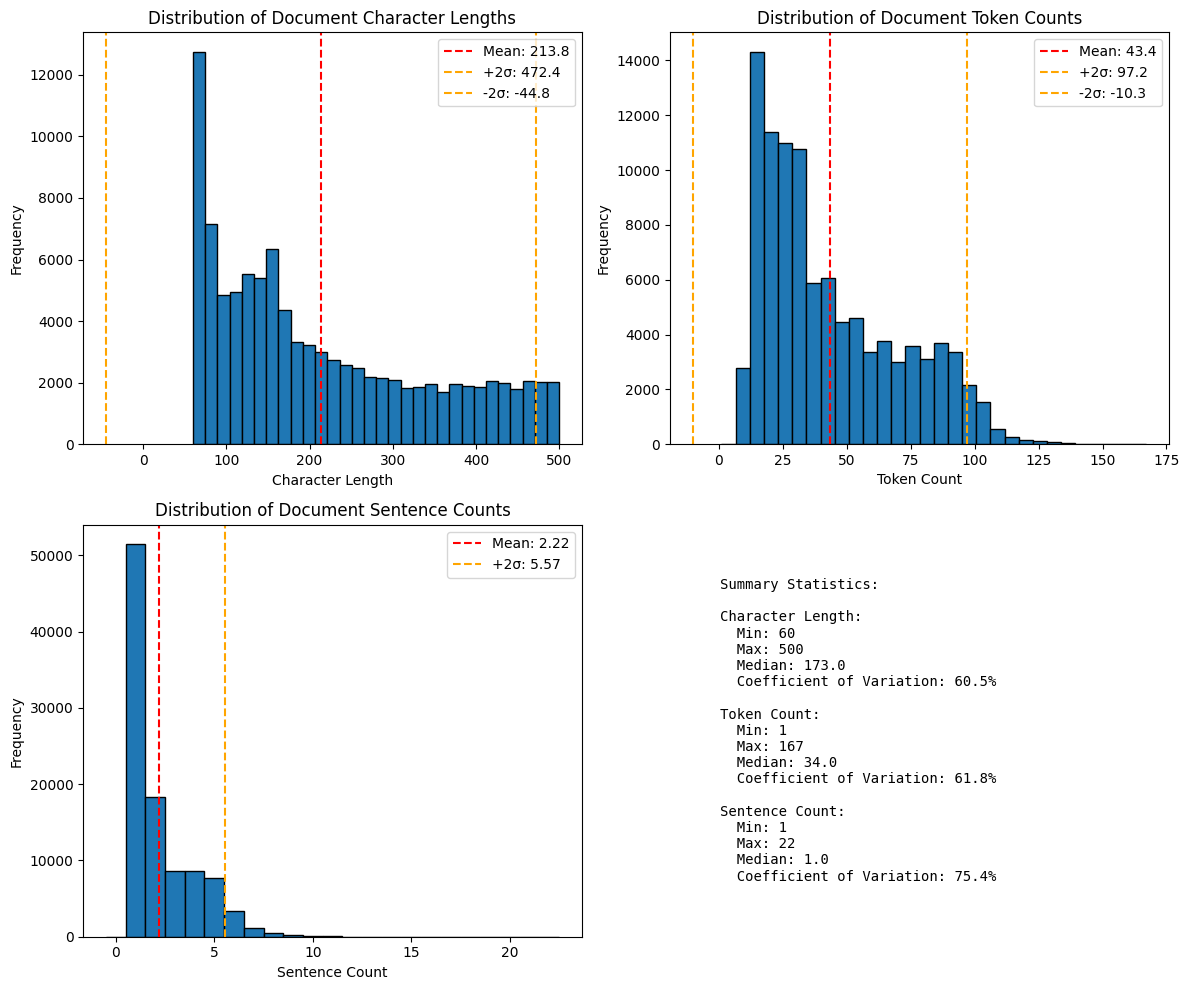


Coefficient of Variation (CV = std/mean):
Character length CV: 60.5%
Token count CV: 61.8%
Sentence count CV: 75.4%

Note: CV > 100% indicates very high variability (std > mean)


In [9]:
# Analyze the distribution of document statistics to check for outliers
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Character length distribution
axes[0, 0].hist(doc_char_lengths, bins=30, edgecolor="black")
axes[0, 0].axvline(
    avg_char_length, color="r", linestyle="--", label=f"Mean: {avg_char_length:.1f}"
)
axes[0, 0].axvline(
    avg_char_length + 2 * std_char_length,
    color="orange",
    linestyle="--",
    label=f"+2σ: {avg_char_length + 2 * std_char_length:.1f}",
)
axes[0, 0].axvline(
    avg_char_length - 2 * std_char_length,
    color="orange",
    linestyle="--",
    label=f"-2σ: {avg_char_length - 2 * std_char_length:.1f}",
)
axes[0, 0].set_xlabel("Character Length")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Distribution of Document Character Lengths")
axes[0, 0].legend()

# Token count distribution
axes[0, 1].hist(doc_token_counts, bins=30, edgecolor="black")
axes[0, 1].axvline(
    avg_token_count, color="r", linestyle="--", label=f"Mean: {avg_token_count:.1f}"
)
axes[0, 1].axvline(
    avg_token_count + 2 * std_token_count,
    color="orange",
    linestyle="--",
    label=f"+2σ: {avg_token_count + 2 * std_token_count:.1f}",
)
axes[0, 1].axvline(
    avg_token_count - 2 * std_token_count,
    color="orange",
    linestyle="--",
    label=f"-2σ: {avg_token_count - 2 * std_token_count:.1f}",
)
axes[0, 1].set_xlabel("Token Count")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Distribution of Document Token Counts")
axes[0, 1].legend()

# Sentence count distribution
axes[1, 0].hist(
    doc_sentence_counts,
    bins=range(0, max(doc_sentence_counts) + 2),
    edgecolor="black",
    align="left",
)
axes[1, 0].axvline(
    avg_sentence_count,
    color="r",
    linestyle="--",
    label=f"Mean: {avg_sentence_count:.2f}",
)
axes[1, 0].axvline(
    avg_sentence_count + 2 * std_sentence_count,
    color="orange",
    linestyle="--",
    label=f"+2σ: {avg_sentence_count + 2 * std_sentence_count:.2f}",
)
axes[1, 0].set_xlabel("Sentence Count")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Distribution of Document Sentence Counts")
axes[1, 0].legend()

# Summary statistics table
axes[1, 1].axis("off")
summary_text = f"""
Summary Statistics:

Character Length:
  Min: {min(doc_char_lengths)}
  Max: {max(doc_char_lengths)}
  Median: {np.median(doc_char_lengths):.1f}
  Coefficient of Variation: {(std_char_length / avg_char_length) * 100:.1f}%

Token Count:
  Min: {min(doc_token_counts)}
  Max: {max(doc_token_counts)}
  Median: {np.median(doc_token_counts):.1f}
  Coefficient of Variation: {(std_token_count / avg_token_count) * 100:.1f}%

Sentence Count:
  Min: {min(doc_sentence_counts)}
  Max: {max(doc_sentence_counts)}
  Median: {np.median(doc_sentence_counts):.1f}
  Coefficient of Variation: {(std_sentence_count / avg_sentence_count) * 100:.1f}%
"""
axes[1, 1].text(
    0.1, 0.5, summary_text, fontsize=10, verticalalignment="center", family="monospace"
)

plt.tight_layout()
plt.show()

print("\nCoefficient of Variation (CV = std/mean):")
print(f"Character length CV: {(std_char_length / avg_char_length) * 100:.1f}%")
print(f"Token count CV: {(std_token_count / avg_token_count) * 100:.1f}%")
print(f"Sentence count CV: {(std_sentence_count / avg_sentence_count) * 100:.1f}%")
print("\nNote: CV > 100% indicates very high variability (std > mean)")

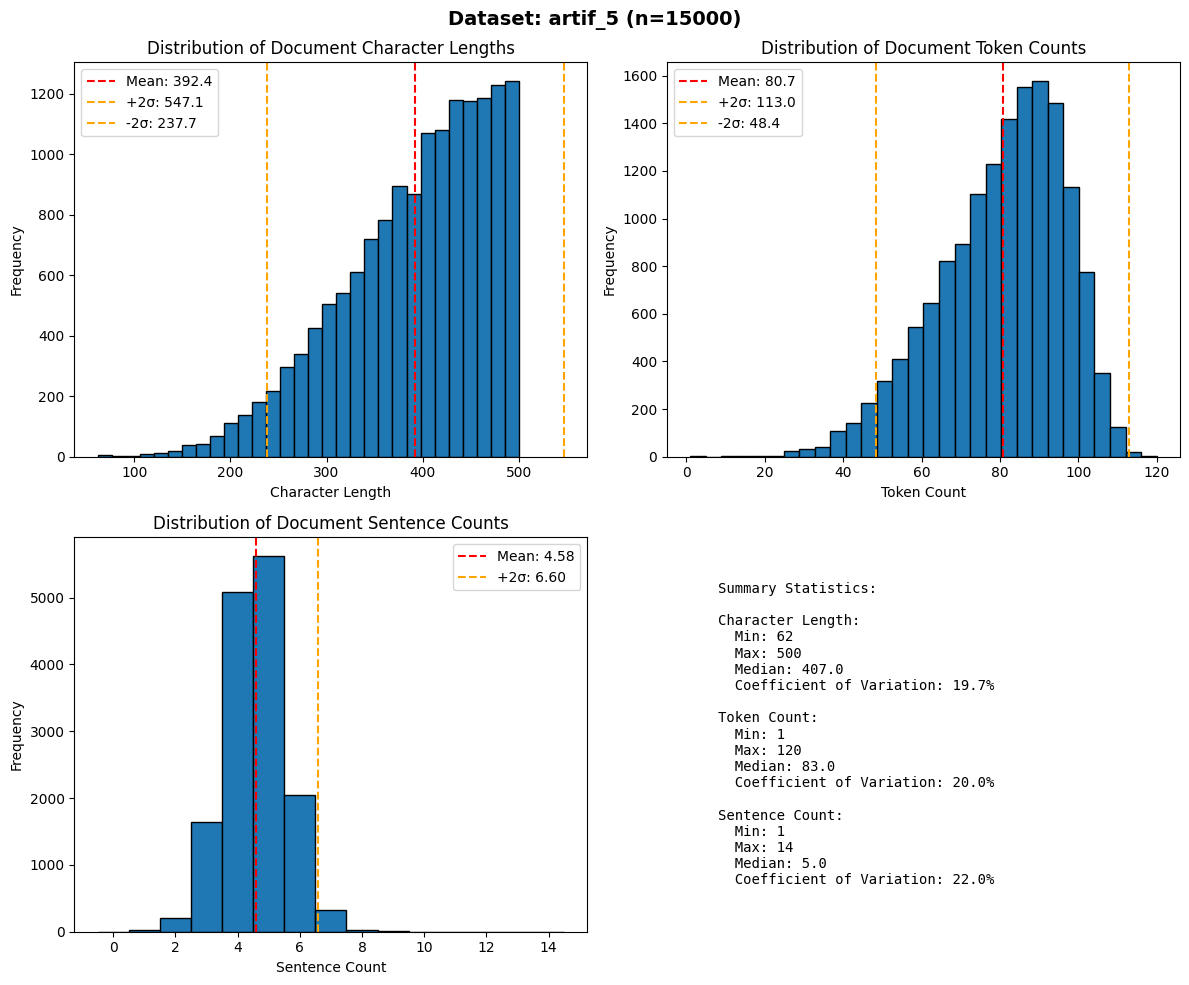


artif_5 - Coefficient of Variation (CV = std/mean):
Character length CV: 19.7%
Token count CV: 20.0%
Sentence count CV: 22.0%


<Figure size 640x480 with 0 Axes>

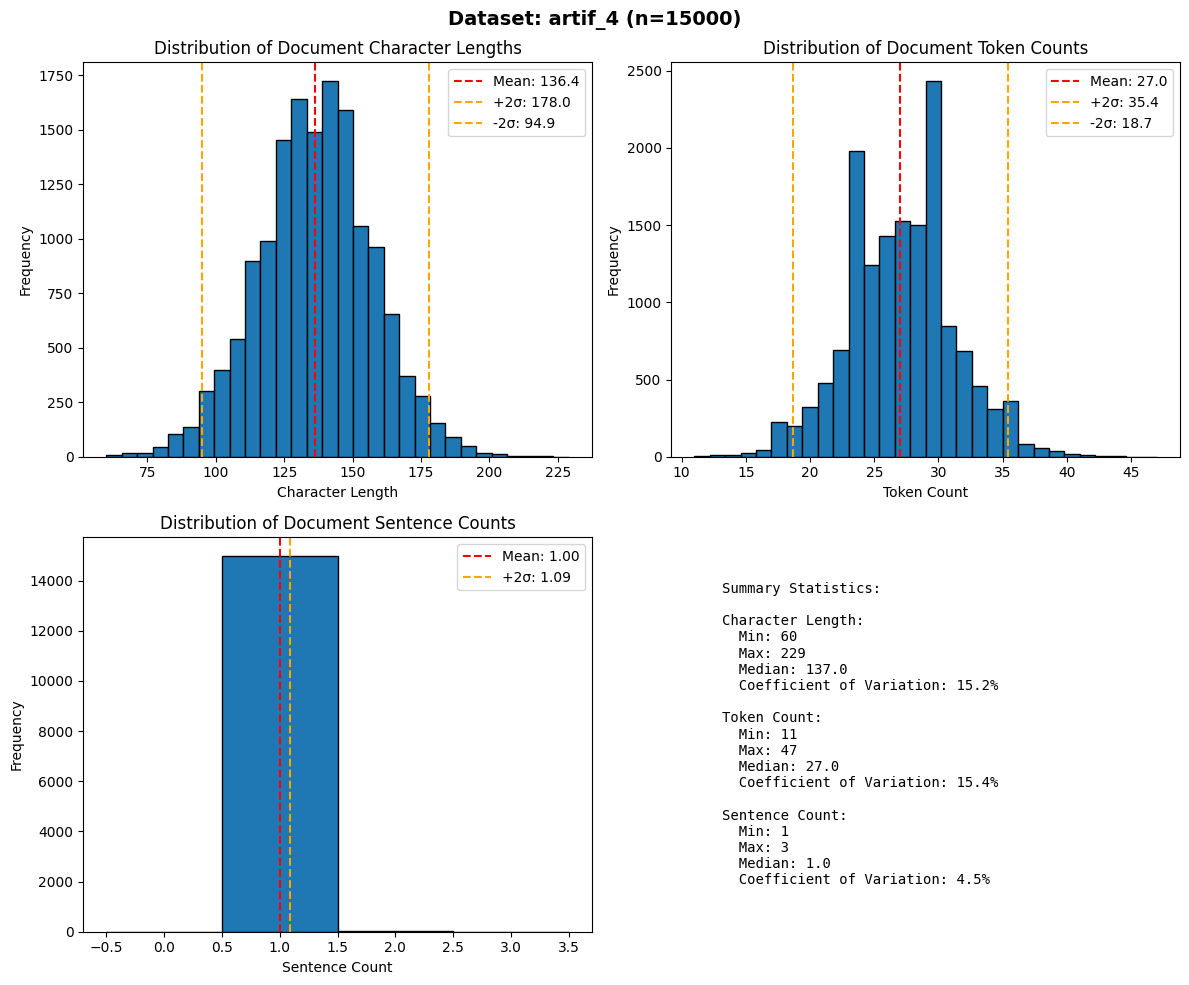


artif_4 - Coefficient of Variation (CV = std/mean):
Character length CV: 15.2%
Token count CV: 15.4%
Sentence count CV: 4.5%


<Figure size 640x480 with 0 Axes>

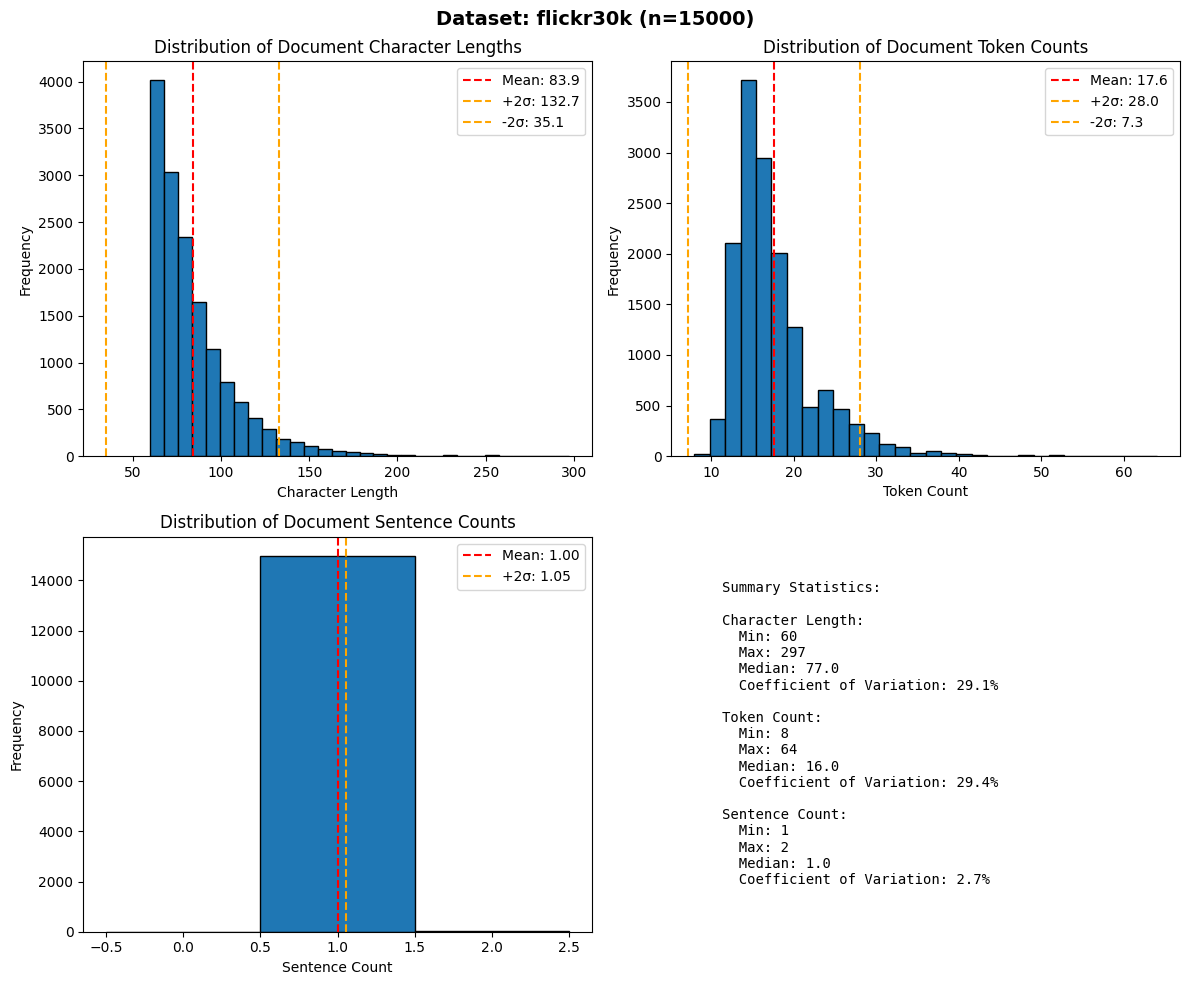


flickr30k - Coefficient of Variation (CV = std/mean):
Character length CV: 29.1%
Token count CV: 29.4%
Sentence count CV: 2.7%


<Figure size 640x480 with 0 Axes>

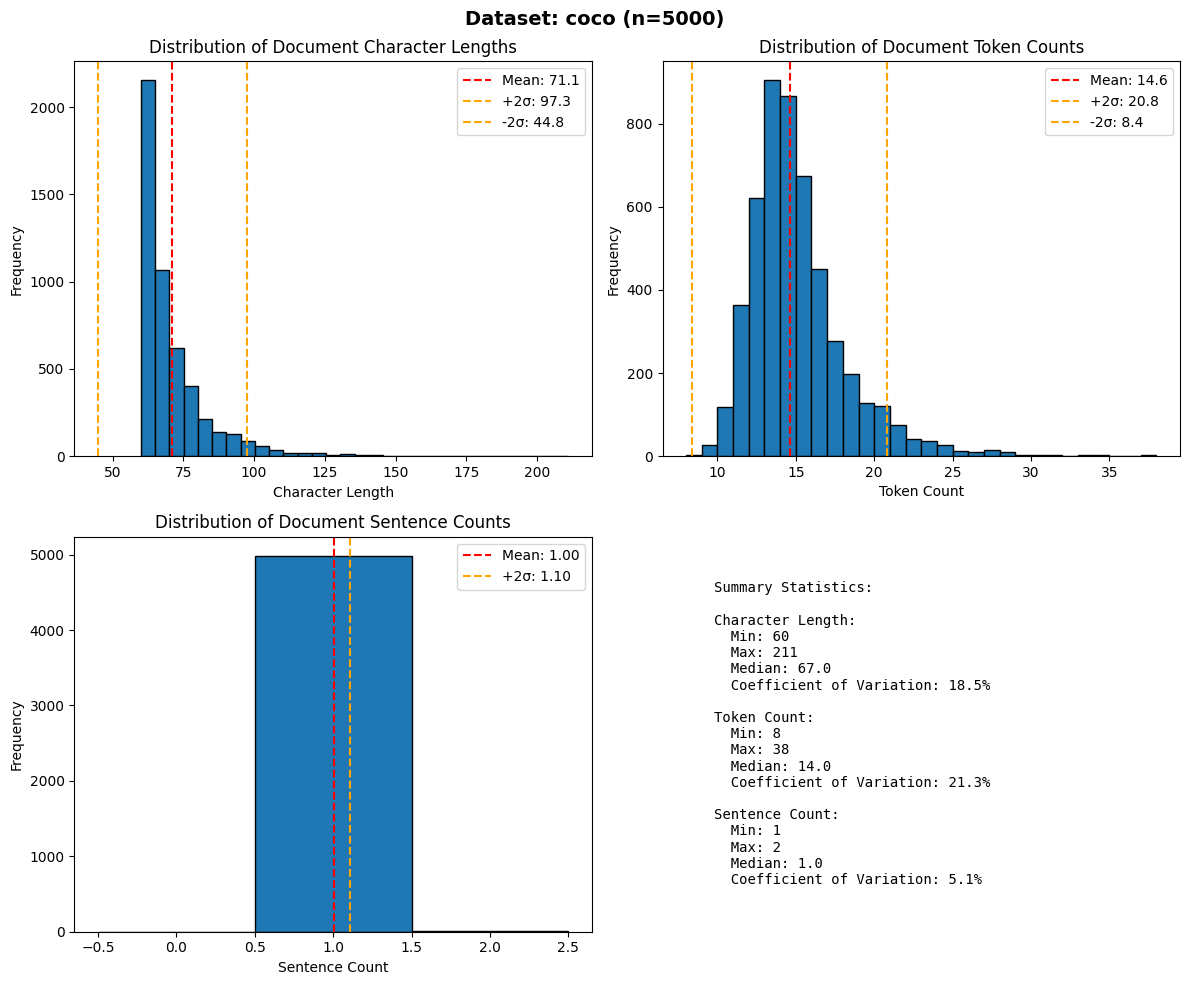


coco - Coefficient of Variation (CV = std/mean):
Character length CV: 18.5%
Token count CV: 21.3%
Sentence count CV: 5.1%


<Figure size 640x480 with 0 Axes>

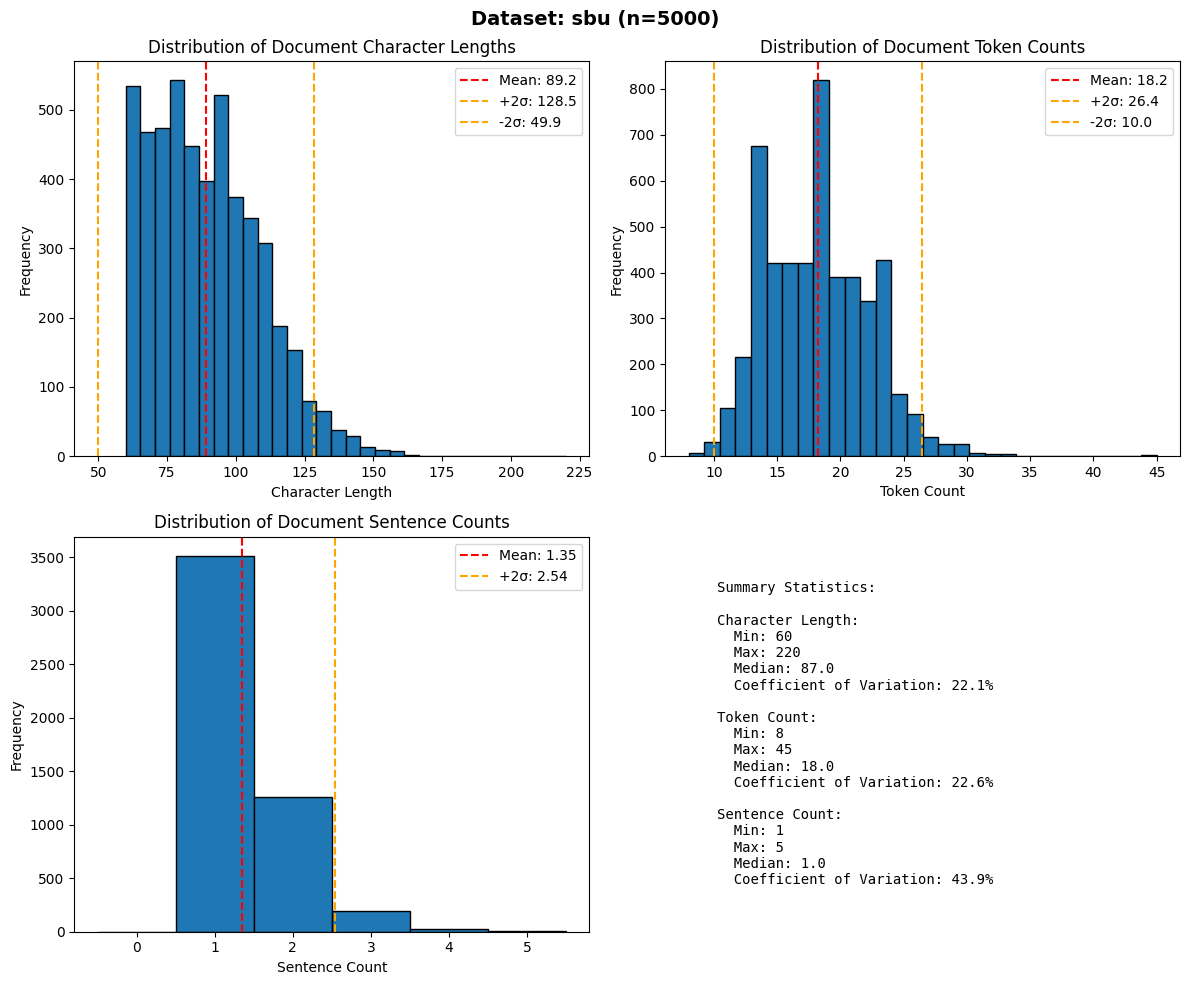


sbu - Coefficient of Variation (CV = std/mean):
Character length CV: 22.1%
Token count CV: 22.6%
Sentence count CV: 43.9%


<Figure size 640x480 with 0 Axes>

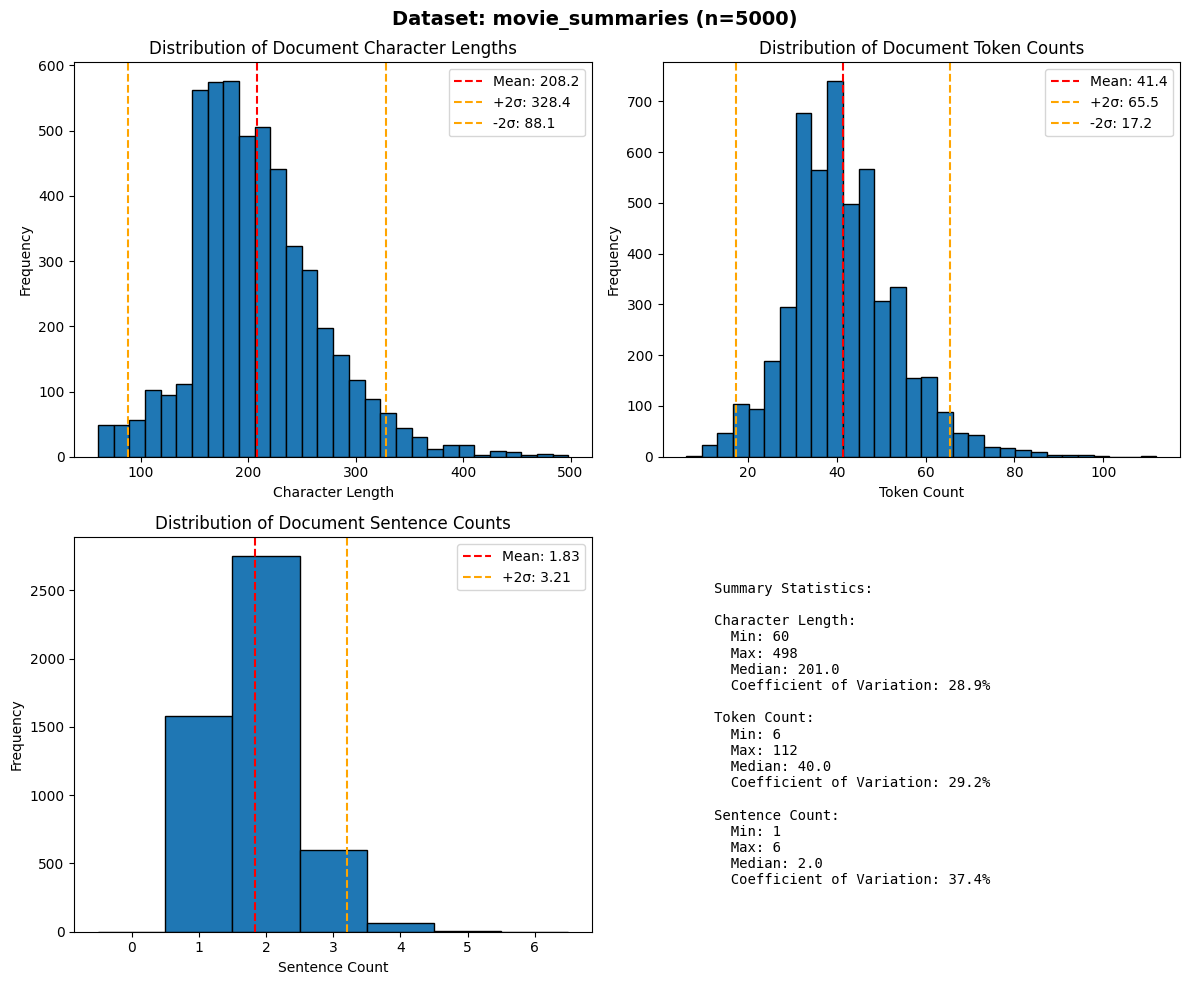


movie_summaries - Coefficient of Variation (CV = std/mean):
Character length CV: 28.9%
Token count CV: 29.2%
Sentence count CV: 37.4%


<Figure size 640x480 with 0 Axes>

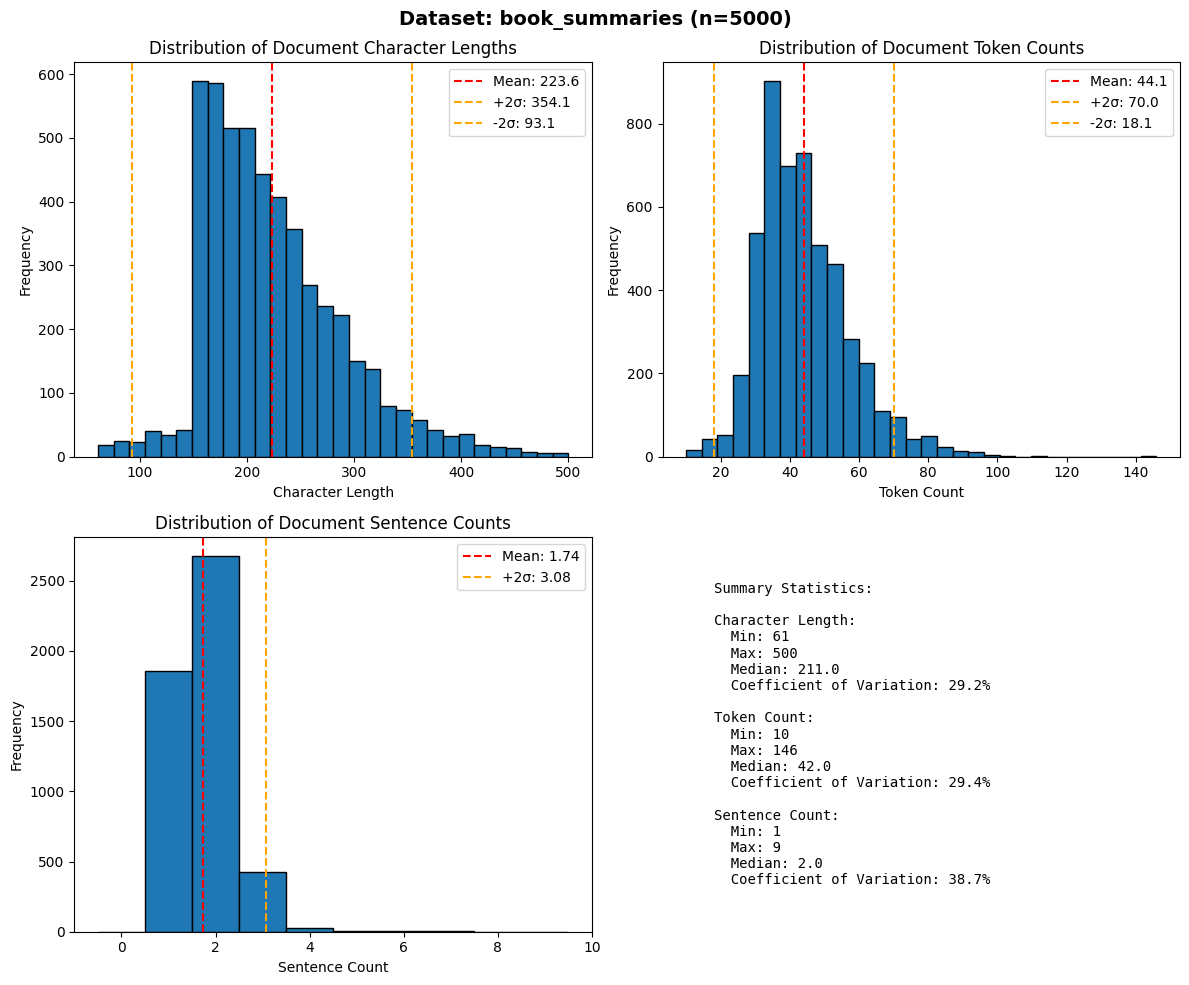


book_summaries - Coefficient of Variation (CV = std/mean):
Character length CV: 29.2%
Token count CV: 29.4%
Sentence count CV: 38.7%


<Figure size 640x480 with 0 Axes>

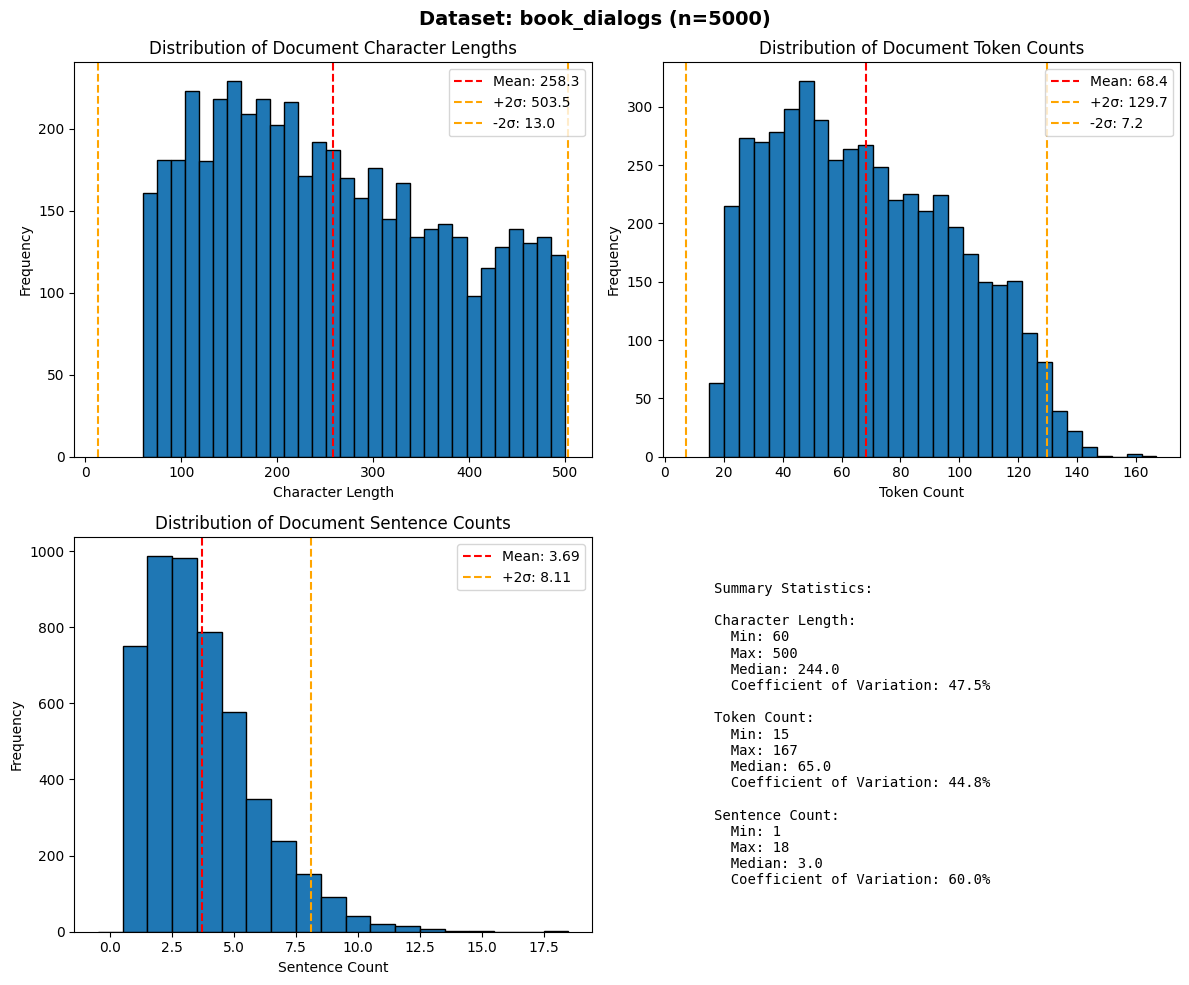


book_dialogs - Coefficient of Variation (CV = std/mean):
Character length CV: 47.5%
Token count CV: 44.8%
Sentence count CV: 60.0%


<Figure size 640x480 with 0 Axes>

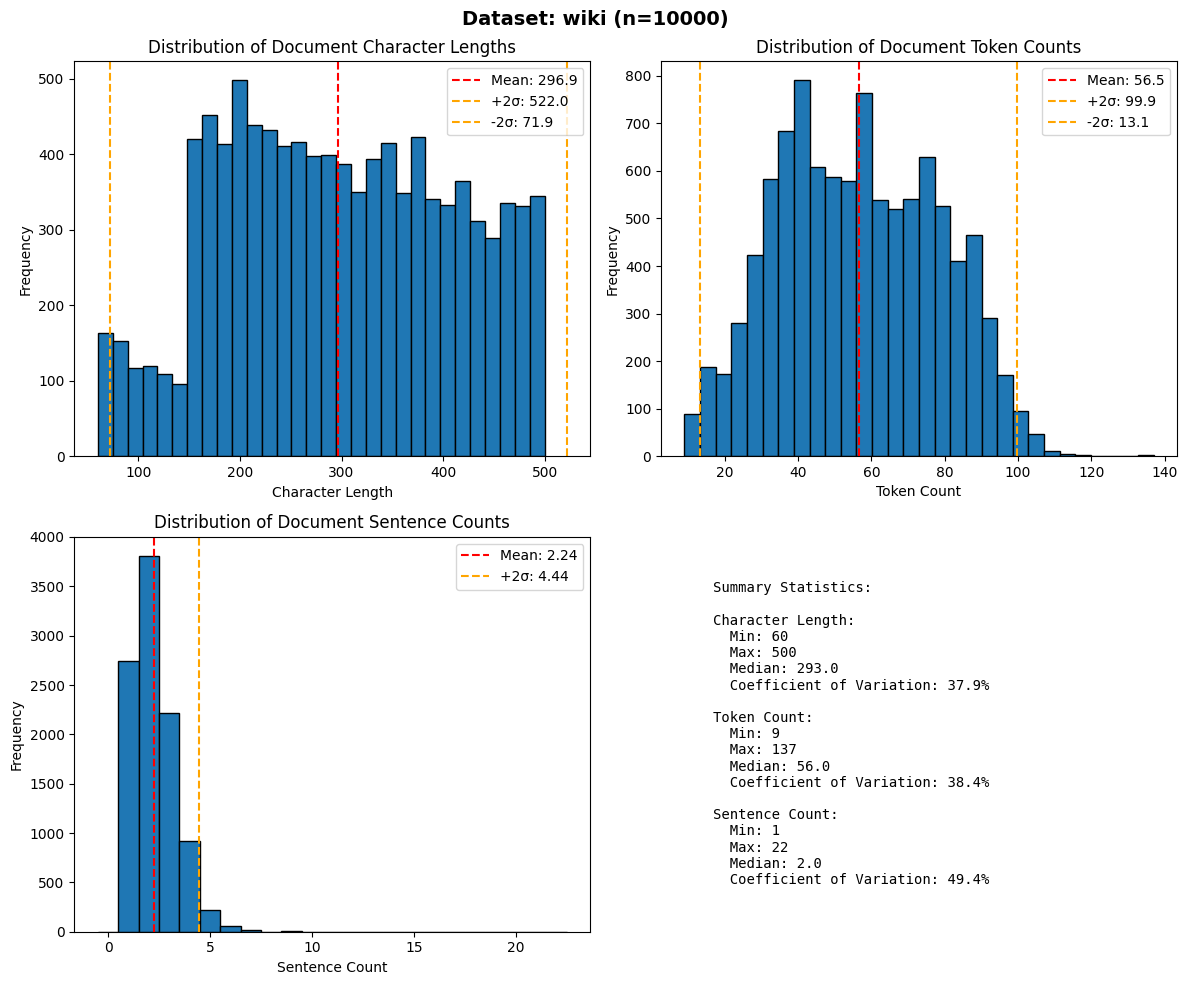


wiki - Coefficient of Variation (CV = std/mean):
Character length CV: 37.9%
Token count CV: 38.4%
Sentence count CV: 49.4%


<Figure size 640x480 with 0 Axes>

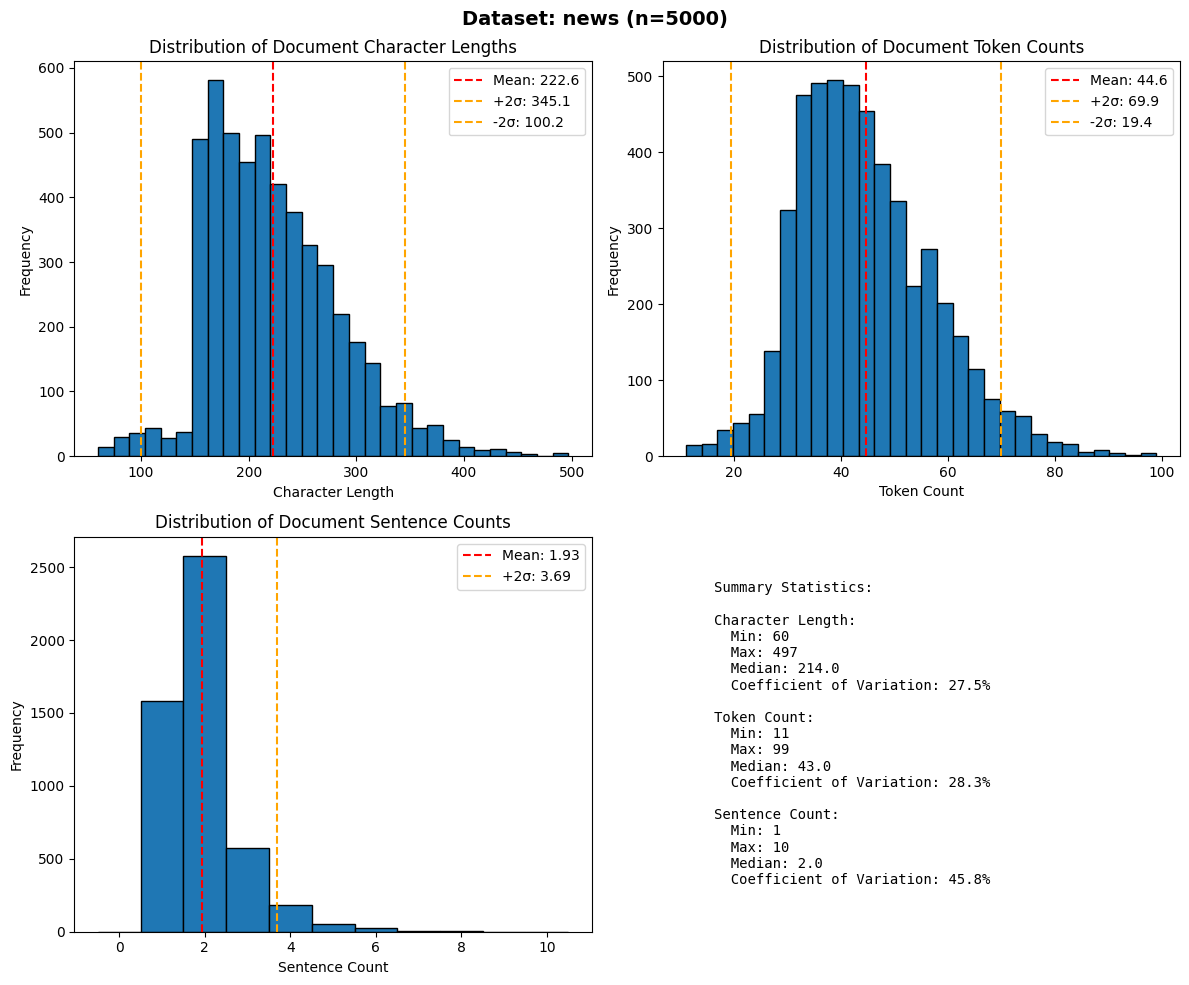


news - Coefficient of Variation (CV = std/mean):
Character length CV: 27.5%
Token count CV: 28.3%
Sentence count CV: 45.8%


<Figure size 640x480 with 0 Axes>

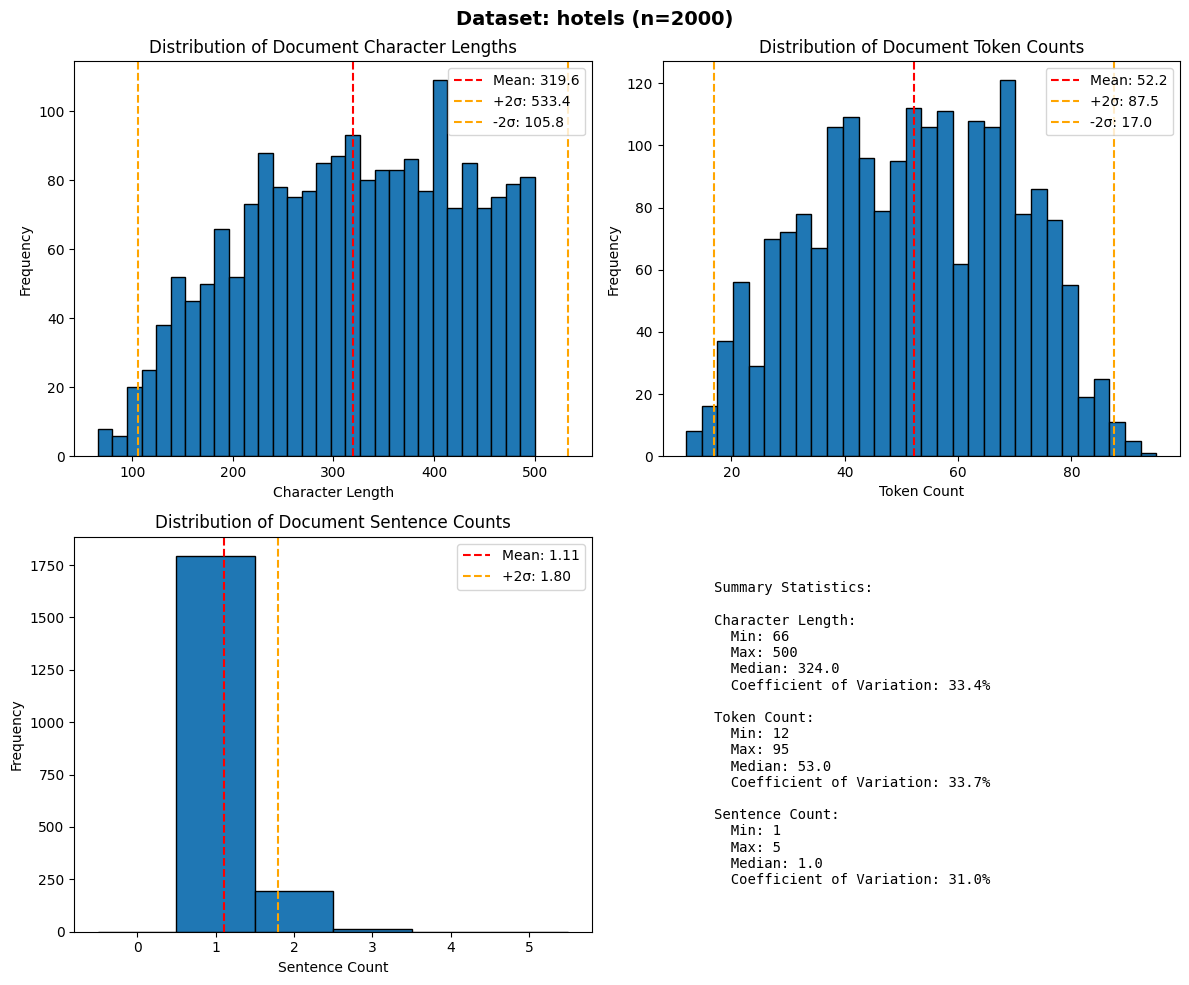


hotels - Coefficient of Variation (CV = std/mean):
Character length CV: 33.4%
Token count CV: 33.7%
Sentence count CV: 31.0%


<Figure size 640x480 with 0 Axes>

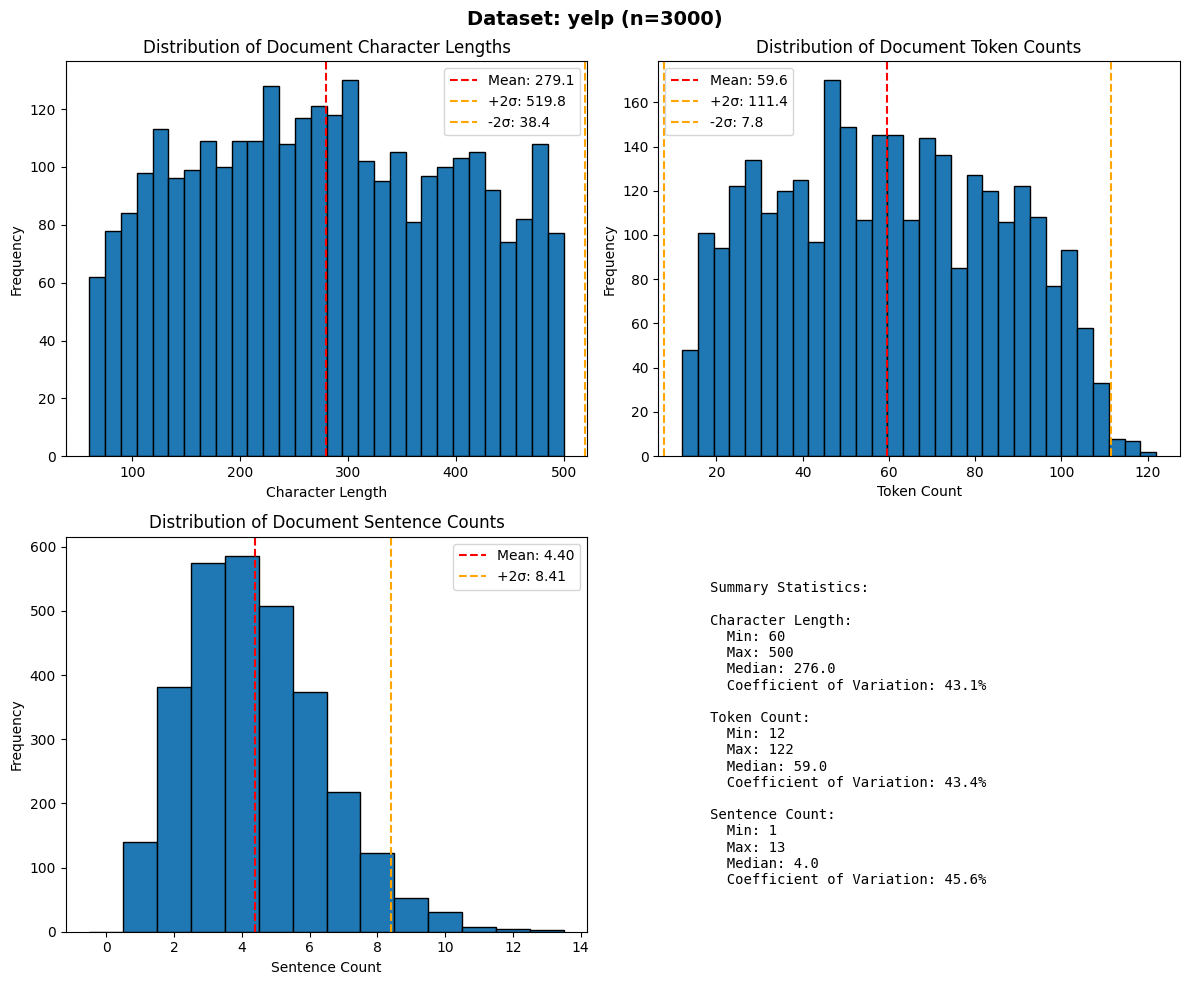


yelp - Coefficient of Variation (CV = std/mean):
Character length CV: 43.1%
Token count CV: 43.4%
Sentence count CV: 45.6%


<Figure size 640x480 with 0 Axes>

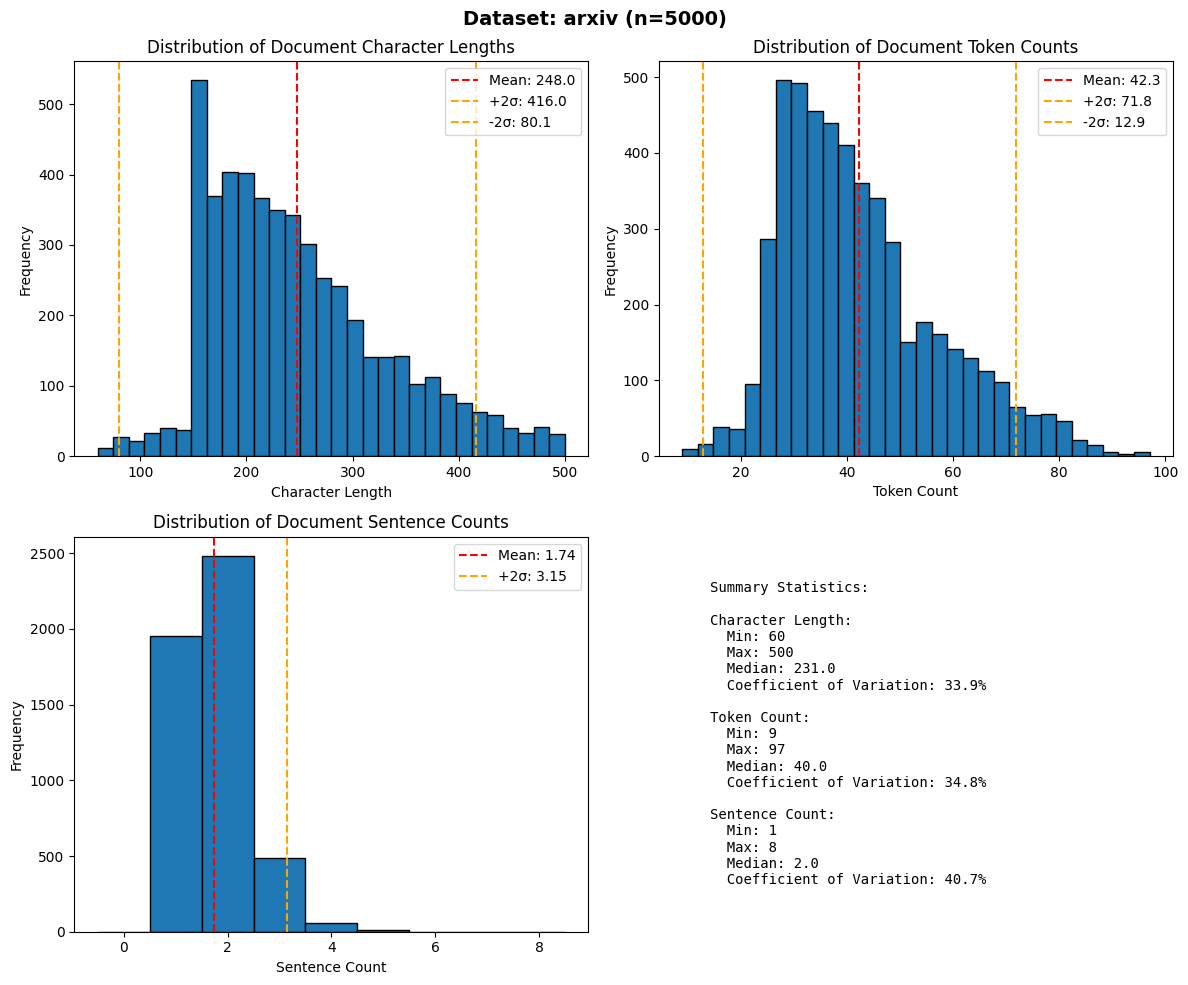


arxiv - Coefficient of Variation (CV = std/mean):
Character length CV: 33.9%
Token count CV: 34.8%
Sentence count CV: 40.7%


<Figure size 640x480 with 0 Axes>

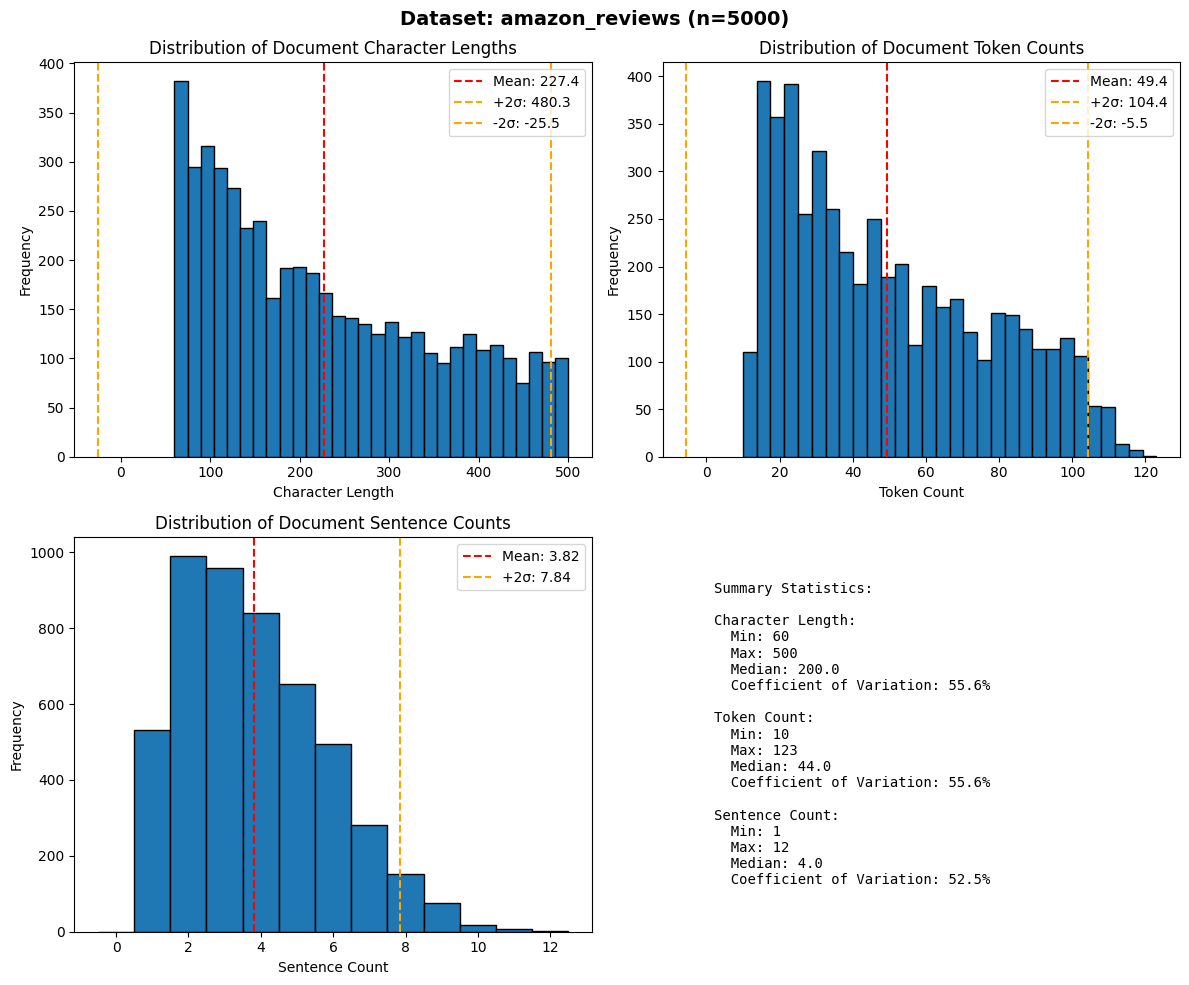


amazon_reviews - Coefficient of Variation (CV = std/mean):
Character length CV: 55.6%
Token count CV: 55.6%
Sentence count CV: 52.5%


<Figure size 640x480 with 0 Axes>

In [11]:
# Per-dataset distribution visualizations
for dataset in token_count_by_dataset:
    dataset_size = len(df_combined[df_combined["dataset"] == dataset])

    # Get dataset-specific values
    ds_char_lengths = doc_char_lengths_by_dataset[dataset]
    ds_token_counts = doc_token_counts_by_dataset[dataset]
    ds_sentence_counts = doc_sentence_counts_by_dataset[dataset]

    # Calculate statistics
    avg_char_length_ds = np.mean(ds_char_lengths)
    std_char_length_ds = np.std(ds_char_lengths)
    avg_tokens = np.mean(ds_token_counts)
    std_tokens_ds = np.std(ds_token_counts)
    avg_sents = np.mean(ds_sentence_counts)
    std_sents_ds = np.std(ds_sentence_counts)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(
        f"Dataset: {dataset} (n={dataset_size})", fontsize=14, fontweight="bold"
    )

    # Character length distribution
    axes[0, 0].hist(ds_char_lengths, bins=30, edgecolor="black")
    axes[0, 0].axvline(
        avg_char_length_ds,
        color="r",
        linestyle="--",
        label=f"Mean: {avg_char_length_ds:.1f}",
    )
    axes[0, 0].axvline(
        avg_char_length_ds + 2 * std_char_length_ds,
        color="orange",
        linestyle="--",
        label=f"+2σ: {avg_char_length_ds + 2 * std_char_length_ds:.1f}",
    )
    axes[0, 0].axvline(
        avg_char_length_ds - 2 * std_char_length_ds,
        color="orange",
        linestyle="--",
        label=f"-2σ: {avg_char_length_ds - 2 * std_char_length_ds:.1f}",
    )
    axes[0, 0].set_xlabel("Character Length")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].set_title("Distribution of Document Character Lengths")
    axes[0, 0].legend()

    # Token count distribution
    axes[0, 1].hist(ds_token_counts, bins=30, edgecolor="black")
    axes[0, 1].axvline(
        avg_tokens, color="r", linestyle="--", label=f"Mean: {avg_tokens:.1f}"
    )
    axes[0, 1].axvline(
        avg_tokens + 2 * std_tokens_ds,
        color="orange",
        linestyle="--",
        label=f"+2σ: {avg_tokens + 2 * std_tokens_ds:.1f}",
    )
    axes[0, 1].axvline(
        avg_tokens - 2 * std_tokens_ds,
        color="orange",
        linestyle="--",
        label=f"-2σ: {avg_tokens - 2 * std_tokens_ds:.1f}",
    )
    axes[0, 1].set_xlabel("Token Count")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].set_title("Distribution of Document Token Counts")
    axes[0, 1].legend()

    # Sentence count distribution
    axes[1, 0].hist(
        ds_sentence_counts,
        bins=range(0, max(ds_sentence_counts) + 2),
        edgecolor="black",
        align="left",
    )
    axes[1, 0].axvline(
        avg_sents, color="r", linestyle="--", label=f"Mean: {avg_sents:.2f}"
    )
    axes[1, 0].axvline(
        avg_sents + 2 * std_sents_ds,
        color="orange",
        linestyle="--",
        label=f"+2σ: {avg_sents + 2 * std_sents_ds:.2f}",
    )
    axes[1, 0].set_xlabel("Sentence Count")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].set_title("Distribution of Document Sentence Counts")
    axes[1, 0].legend()

    # Summary statistics table
    axes[1, 1].axis("off")
    summary_text = f"""
Summary Statistics:

Character Length:
  Min: {min(ds_char_lengths)}
  Max: {max(ds_char_lengths)}
  Median: {np.median(ds_char_lengths):.1f}
  Coefficient of Variation: {(std_char_length_ds / avg_char_length_ds) * 100:.1f}%

Token Count:
  Min: {min(ds_token_counts)}
  Max: {max(ds_token_counts)}
  Median: {np.median(ds_token_counts):.1f}
  Coefficient of Variation: {(std_tokens_ds / avg_tokens) * 100:.1f}%

Sentence Count:
  Min: {min(ds_sentence_counts)}
  Max: {max(ds_sentence_counts)}
  Median: {np.median(ds_sentence_counts):.1f}
  Coefficient of Variation: {(std_sents_ds / avg_sents) * 100:.1f}%
"""
    axes[1, 1].text(
        0.1,
        0.5,
        summary_text,
        fontsize=10,
        verticalalignment="center",
        family="monospace",
    )

    plt.tight_layout()
    plt.show()
    plt.savefig(DATA_DIR / "datasets" / "large" / f"{dataset}_stats.png")

    print(f"\n{dataset} - Coefficient of Variation (CV = std/mean):")
    print(
        f"Character length CV: {(std_char_length_ds / avg_char_length_ds) * 100:.1f}%"
    )
    print(f"Token count CV: {(std_tokens_ds / avg_tokens) * 100:.1f}%")
    print(f"Sentence count CV: {(std_sents_ds / avg_sents) * 100:.1f}%")